# To make a phase curve

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import juliet as jl
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib import rcParams
from pylab import *

/home/jayshil/anaconda3/lib/python3.8/site-packages/autograd/numpy/numpy_wrapper.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  int_types = {_np.int, _np.int8, _np.int16, _np.int32, _np.int64, _np.integer}


In [2]:
# For font etc. styling

sns.set_context("talk")
sns.set_style("ticks")

# Fonts:
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
matplotlib.rcParams.update({'font.size':12})
plt.rc('legend', **{'fontsize':12})

# Ticks to the outside:
rcParams['axes.linewidth'] = 1.2 
rcParams['xtick.direction'] = 'out'
rcParams['ytick.direction'] = 'out'

In [3]:
# To load data from the folder
dataset = jl.load(input_folder='multisector_in_transit_ExpMatern')

In [4]:
# Creating result object
res1 = dataset.fit(sampler='dynamic_dynesty')

Detected dynamic_dynesty sampler output files --- extracting from multisector_in_transit_ExpMatern/_dynesty_DNS_posteriors.pkl


In [5]:
# Making phases
P, t0 = np.median(res1.posteriors['posterior_samples']['P_p1']),\
        np.median(res1.posteriors['posterior_samples']['t0_p1'])

(-0.025, 0.025)

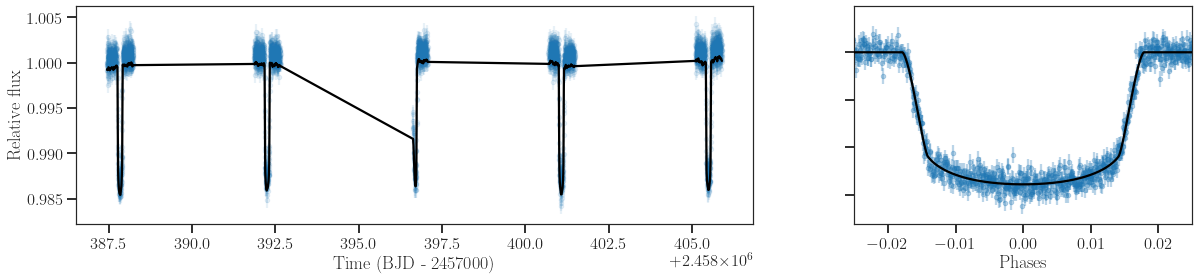

In [6]:
# Sector
sec = 'TESS3'

# Phases
phases = jl.get_phases(dataset.times_lc[sec], P, t0)

# Extract full model:
transit_plus_GP_model = res1.lc.evaluate(sec)

# Deterministic part of the model (in our case transit divided by mflux):
transit_model = res1.lc.model[sec]['deterministic']
fac = 1/np.max(transit_model)

# GP part of the model:
gp_model = res1.lc.model[sec]['GP']

# Now plot. First preambles:
fig = plt.figure(figsize=(20,4))
gs = gridspec.GridSpec(1, 2, width_ratios=[2,1])
ax1 = plt.subplot(gs[0])

# Plot data
ax1.errorbar(dataset.times_lc[sec], dataset.data_lc[sec]*fac, \
             yerr = dataset.errors_lc[sec]*fac, fmt = '.', alpha = 0.1)

# Plot the (full, transit + GP) model:
ax1.plot(dataset.times_lc[sec], transit_plus_GP_model, color='black',zorder=10)

#ax1.set_xlim([1328,1350])
#ax1.set_ylim([0.96,1.04])
ax1.set_xlabel('Time (BJD - 2457000)')
ax1.set_ylabel('Relative flux')

ax2 = plt.subplot(gs[1])

# Now plot phase-folded lightcurve but with the GP part removed:
ax2.errorbar(phases, dataset.data_lc[sec]*fac - gp_model, \
             yerr = dataset.errors_lc[sec]*fac, fmt = '.', alpha = 0.3)

# Plot transit-only (divided by mflux) model:
idx = np.argsort(phases)
ax2.plot(phases[idx],transit_model[idx]*fac, color='black',zorder=10)
ax2.yaxis.set_major_formatter(plt.NullFormatter())
ax2.set_xlabel('Phases')
ax2.set_xlim([-0.025,0.025])
#ax2.set_ylim([0.96,1.04])

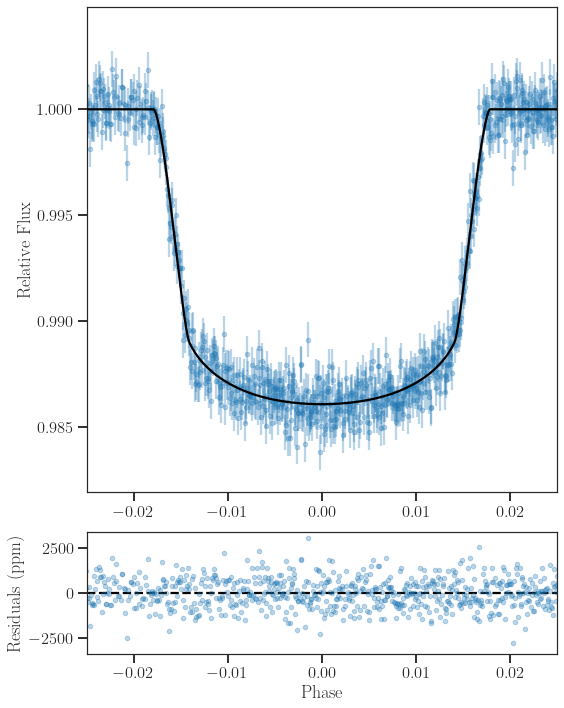

In [7]:
# Sector
sec = 'TESS3'

# Phases
phases = jl.get_phases(dataset.times_lc[sec], P, t0)

data_phs = dataset.data_lc[sec]*fac - gp_model
data_err_phs = dataset.errors_lc[sec]*fac

resid = (data_phs - transit_model*fac)*1e6

fig_a = plt.figure(figsize = (8,10))
gs_a = gridspec.GridSpec(2, 1, height_ratios = [4,1])

ax11 = plt.subplot(gs_a[0])
ax11.errorbar(phases, data_phs, yerr=data_err_phs, fmt='.', alpha=0.3)
ax11.plot(phases[idx], transit_model[idx]*fac, c='black', zorder=10)
ax11.set_ylabel('Relative Flux')

ax22 = plt.subplot(gs_a[1], sharex = ax11)
ax22.errorbar(phases, resid, fmt='.', alpha=0.3)
ax22.axhline(y=0.0, c='black', ls='--')
ax22.set_ylabel('Residuals (ppm)')


plt.xlim([-0.025, 0.025])
plt.xlabel('Phase')
plt.tight_layout()
plt.savefig('phot_planet1_instrument_TESS.pdf')

Text(0.5, 0, 'Phase')

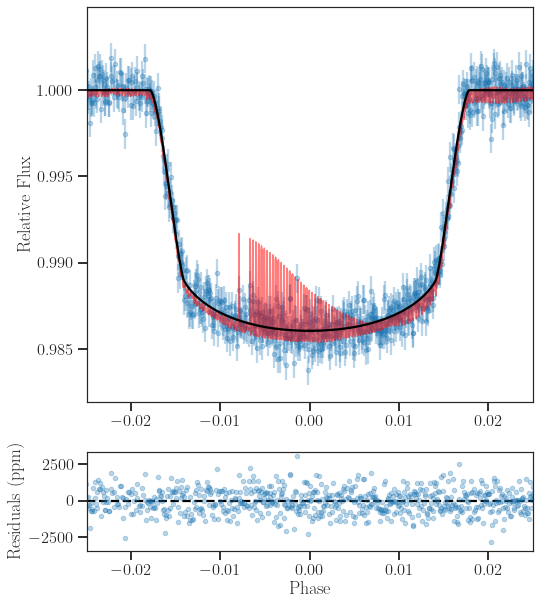

In [8]:
# Sector
sec = 'TESS3'

# Phases
phases = jl.get_phases(dataset.times_lc[sec], P, t0)

# Extract full model:
transit_plus_GP_model, errup, errdo = res1.lc.evaluate(sec, t=dataset.times_lc[sec], GPregressors=dataset.times_lc[sec], return_err=True)

# Deterministic part of the model (in our case transit divided by mflux):
transit_model = res1.lc.model[sec]['deterministic']
model_ue = res1.lc.model[sec]['deterministic_uerror']
model_le = res1.lc.model[sec]['deterministic_lerror']

# For normalisation
fac = 1/np.max(transit_model)

# GP part of the model:
gp_model = res1.lc.model[sec]['GP']

data_phs = (dataset.data_lc[sec] - gp_model)*fac
data_err_phs = dataset.errors_lc[sec]*fac

resid = (data_phs - transit_model*fac)*1e6

fig_a = plt.figure(figsize = (8,10))
gs_a = gridspec.GridSpec(2, 1, height_ratios = [4,1])

ax11 = plt.subplot(gs_a[0])
ax11.errorbar(phases, data_phs, yerr=data_err_phs, fmt='.', alpha=0.3)
ax11.plot(phases[idx], transit_model[idx]*fac, c='black', zorder=10)
ax11.fill_between(phases[idx], errup[idx], errdo[idx], color='red', alpha=0.5, zorder=5)
ax11.set_ylabel('Relative Flux')

ax22 = plt.subplot(gs_a[1], sharex = ax11)
ax22.errorbar(phases, resid, fmt='.', alpha=0.3)
ax22.axhline(y=0.0, c='black', ls='--')
ax22.set_ylabel('Residuals (ppm)')


plt.xlim([-0.025, 0.025])
plt.xlabel('Phase')